# Tutorial 9a: Basic image filtering and thresholding

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](t9a_basic_filtering_and_thresholding.ipynb).*

In this tutorial, we will develop our image processing skills on the data set provided by Jin Park from the Elowitz lab.  These are unpublished results, so please keep them within Caltech.

In [1]:
import warnings

# Our numerical workhorse
import numpy as np

# Image processing tools
import skimage
import skimage.io
import skimage.filters
import skimage.morphology

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## The data set

Jin gave us a talk about the data set.  The central question is whether expression of genes requiring two different $\sigma$ factors is correlated.  I.e., do the $\sigma$ factors "share" the available RNA polymerases at the same time, or does one $\sigma$ factor get all of the polymerases while the other does not.

The use of $\sigma$ factors is studied by inserting a fluorescent reporter next to a promoter that requires a $\sigma$ factor of interest.  The two $\sigma$ factors we will consider are $\sigma_B$ and $\sigma_W$, with YFP and CFP fluorescent reporters.  The model organism is *Bacillus subtilis*.  The bacteria also have constitutively expressed RFP for segmentation purposes.

Ideally, we would consider images taken over time.  In this case, we have several snapshots of images.  By considering the statistics of several snapshots, we can check to see if $\sigma_B$ and $\sigma_W$ are active in gene expression at the same time.

For each snapshot, we have four images.
1. A phase contrast image for reference.
2. An RFP image for segementation.
3. A CFP image.
4. A YFP image.

There are four different strains.  We have
1. $\sigma_B$-CFP, $\sigma_W$-YFP, constitutive RFP
2. $\sigma_B$-CFP, $\sigma_B$-YFP, constitutive RFP
3. $\sigma_W$-CFP, $\sigma_W$-YFP, constitutive RFP
4. only constitutive RFP; no CFP or YFP

The files are named so that we can tell which strain and which channel we are considering.  If we were to write a string for the file name in Python, we would do:
`snaps%03d-%03d-%s.tif % (strain, field_of_view, channel)`.

As an example, the file named `snaps002-007-r.tif` is the RFP channel for strain 2 for the seventh field of view that was acquired.  The file named `snaps001-004-p.tif` is a phase constrast image of strain 1 in the fourth field of view.

The interpixel distance for this camera/objective set-up is 0.065 µm.

Finally, the phase, YFP, and CFP channels have 2$\times$2 **binning**.  This means that each pixel in the image comes from combining the values of a 2$\times$2 array of pixels.  This is often done when signal is low to boost the signal to noise ratio.

### Let's have a look

Let's take a look at the images.  We will use `skimage.io.imread` to load the images and `plt.imshow` to show them.  We use the latter because it enables us to use subplots.

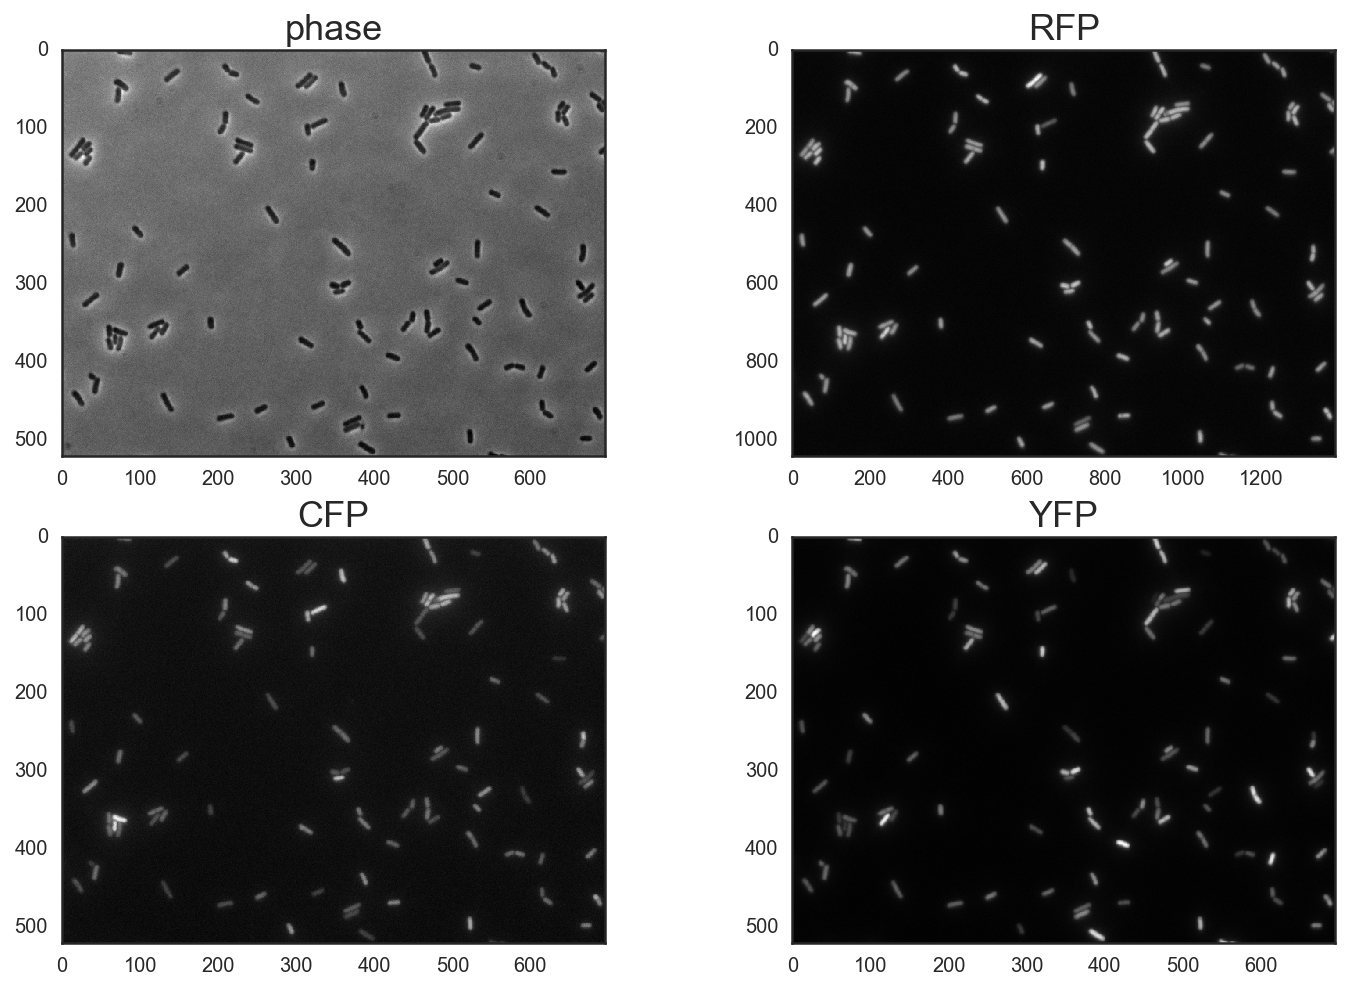

In [2]:
# Define directory containing files
image_dir = '../data/park_et_al/'

# Get image file names
im_p_file = image_dir + 'snaps001-001-p.tif'
im_r_file = image_dir + 'snaps001-001-r.tif'
im_c_file = image_dir + 'snaps001-001-c.tif'
im_y_file = image_dir + 'snaps001-001-y.tif'

# Load images and store in list [phase, RFP, CFP, YFP]
im_names = ['phase', 'RFP', 'CFP', 'YFP']
ims = [skimage.io.imread(im_p_file),
       skimage.io.imread(im_r_file),
       skimage.io.imread(im_c_file),
       skimage.io.imread(im_y_file)]

# Say which images go in which subplots
im_sp = [(0,0), (0,1), (1,0), (1,1)]

# Display images
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    for i in range(4):
        ax[im_sp[i]].imshow(ims[i], cmap=plt.cm.gray)
        ax[im_sp[i]].set_title(im_names[i])

We notice that the binning reduces the dimensions of the phase, CFP, and YFP channels.  We have just "plotted" the images, but let's get some more information.  First, `skimage.io` automatically detected data types.  Let's see what it detected.

In [3]:
# Print the data types of the images
for i in range(4):
    print(im_names[i], ':', ims[i].dtype)

phase : uint16
RFP : uint16
CFP : uint16
YFP : uint16


They are all 16-bit images.  We can learn more about the pixel values by looking at their **histograms**.  We we talk about the histogram of an image, we are referring to the counts of the pixel values in the image.  To compute the histograms, we use the `skimage.exposure.histogram` function.  We then plot the histogram using `plt.fill_between`.  In my opinion, this results in nice-looking histograms that are easy to interpret.

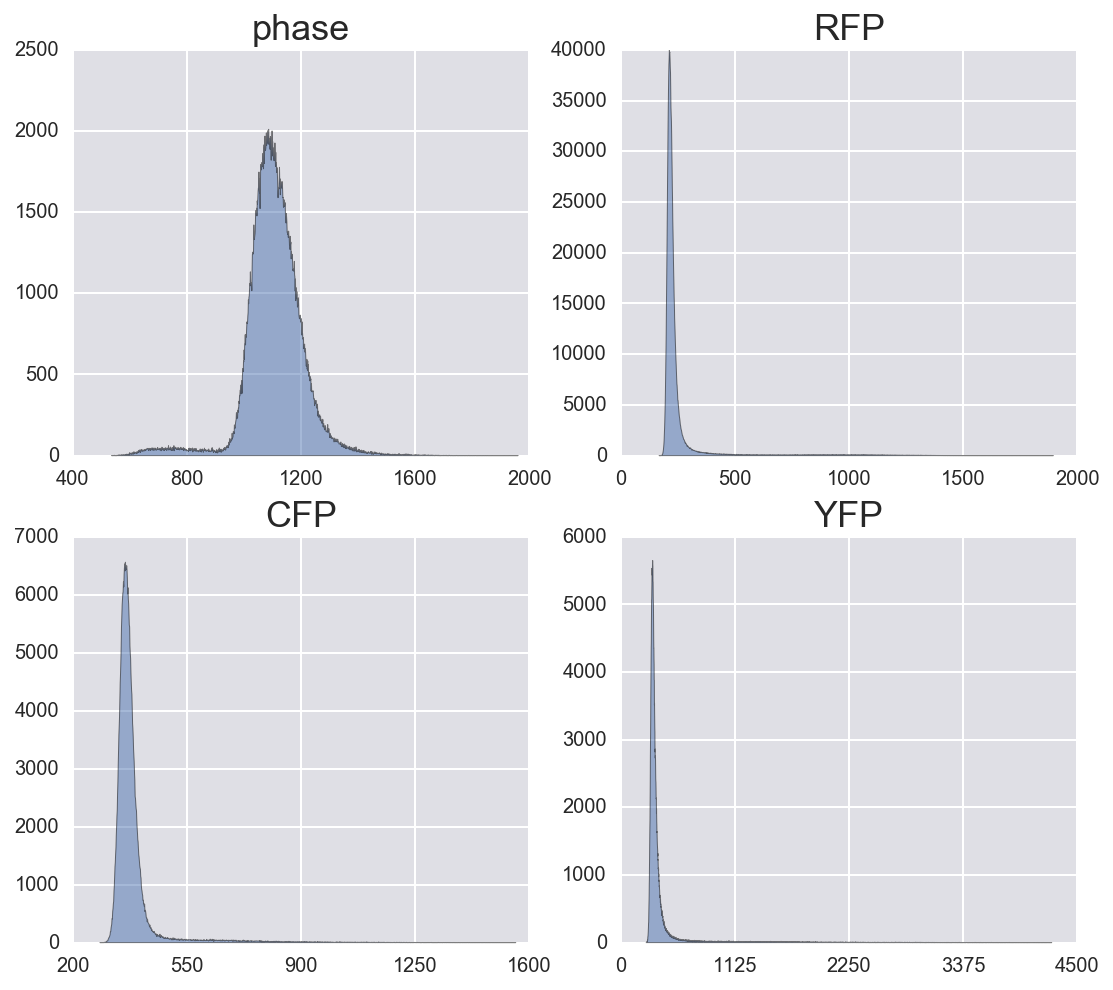

In [4]:
# Compute histograms
hist, bins = 4*[None], 4*[None]
for i in range(4):
    hist[i], bins[i] = skimage.exposure.histogram(ims[i])

# Display histograms
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
for i in range(4):
    ax[im_sp[i]].fill_between(bins[i], hist[i], lw=0.5, alpha=0.5)
    ax[im_sp[i]].set_title(im_names[i])
    
    # Only do five ticks
    start, end = ax[im_sp[i]].get_xlim()
    ax[im_sp[i]].xaxis.set_ticks(np.linspace(start, end, 5))

We see that all of the fluorescence channels have a sharp peak at low intensity values.  This is the black background.  Conversely, the phase image has a big peak at a higher intensity, which is the white background.

It is often easier to look at the histograms on a log scale.

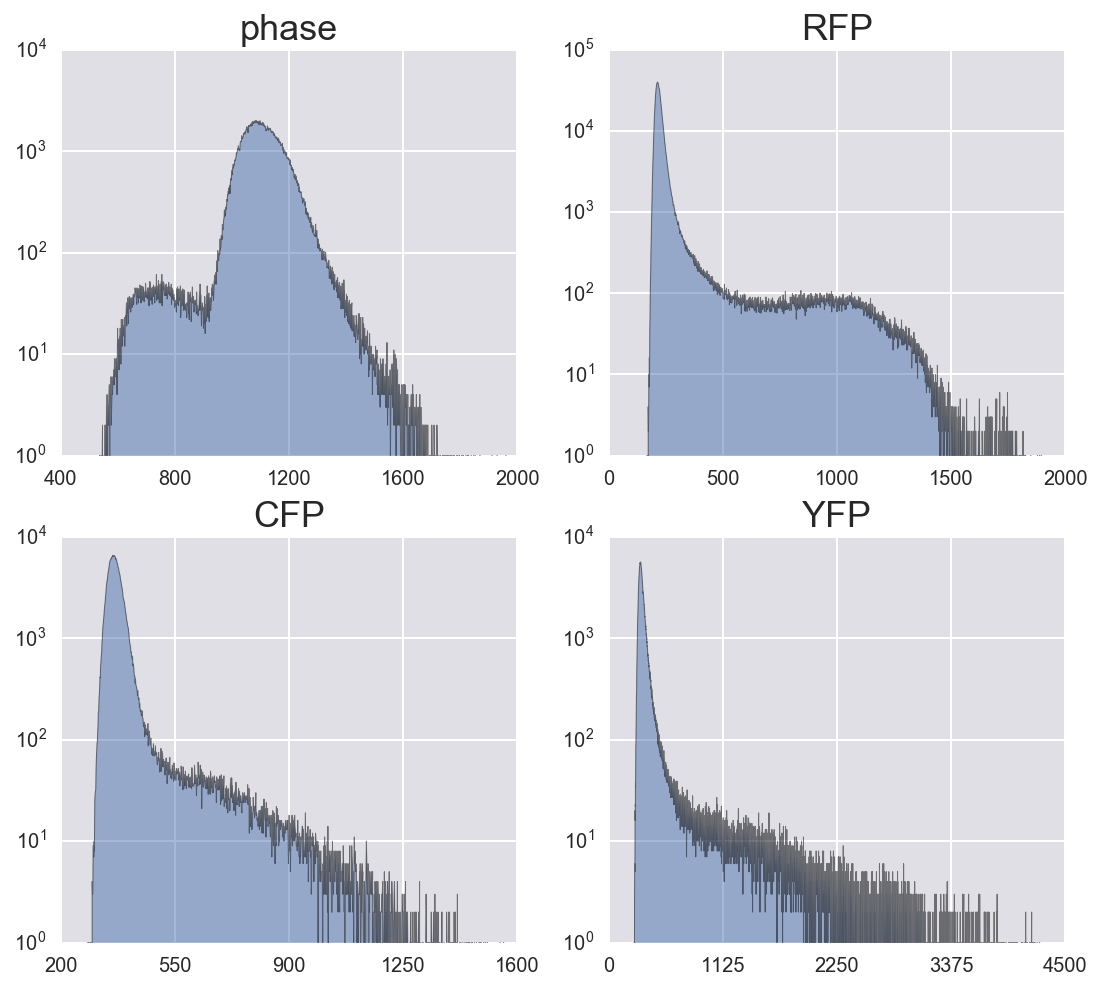

In [5]:
# Display histograms with log scale
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
for i in range(4):
    ax[im_sp[i]].fill_between(bins[i], hist[i], lw=0.5, alpha=0.5)
    ax[im_sp[i]].set_title(im_names[i])
    
    # Only do five ticks
    start, end = ax[im_sp[i]].get_xlim()
    ax[im_sp[i]].xaxis.set_ticks(np.linspace(start, end, 5))
    
    # Log scale on y-axis
    ax[im_sp[i]].set_yscale('log')

It is now easier to see the features (bacteria) in the histograms.  For the fluorescence channels, these are the higher intensities.  For the phase image, they are the lower intensities.  The histograms are just another way of "plotting" an image, and can provide insights.  In this case, we see that the images use nowhere near the full range of pixel values for 16-bit images (0 to 65535).

For the next portion of this tutorial, we will focus on the phase image to learn some basic image processing techniques.

## Cleaning images

The fluorescence images are very "clean."  They have great signal to noise, and the boundaries between bacteria and background are clear.  The phase image is a bit dirtier.  We will use the phase image to illustrate some basic techniques in cleaning up images and to introduce some of the basic concepts in morphological image processing.

Let's start by taking a closer look at it.

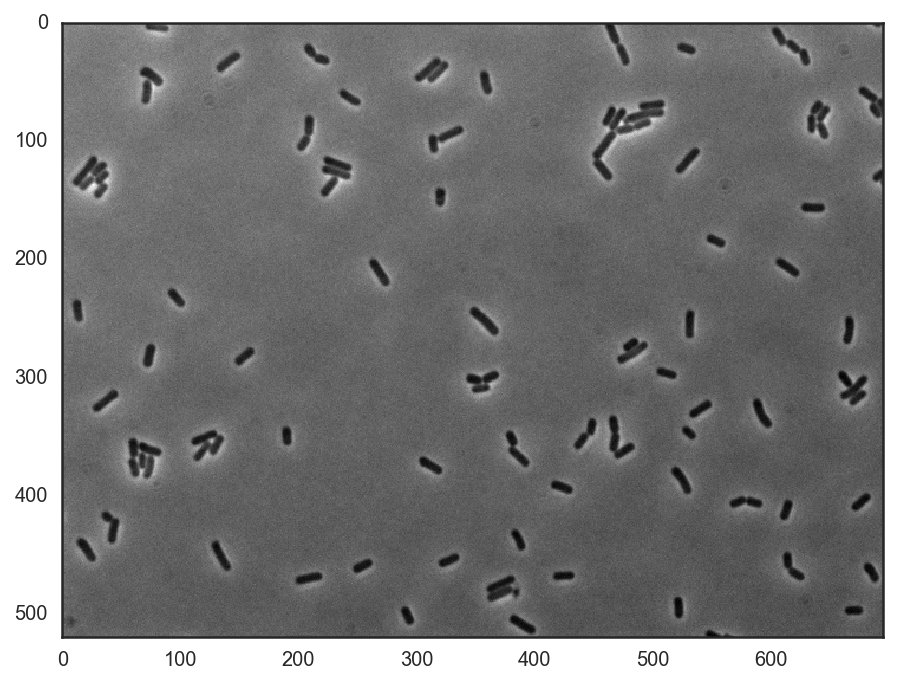

In [6]:
# Rename ims[0] to im for convenience
im = np.copy(ims[0])

# Display phase image
with sns.axes_style('white'):
    plt.imshow(im, cmap=plt.cm.gray)

### Background subtraction

When we look at the image with false coloring, we can see more of the potentially troublesome features.

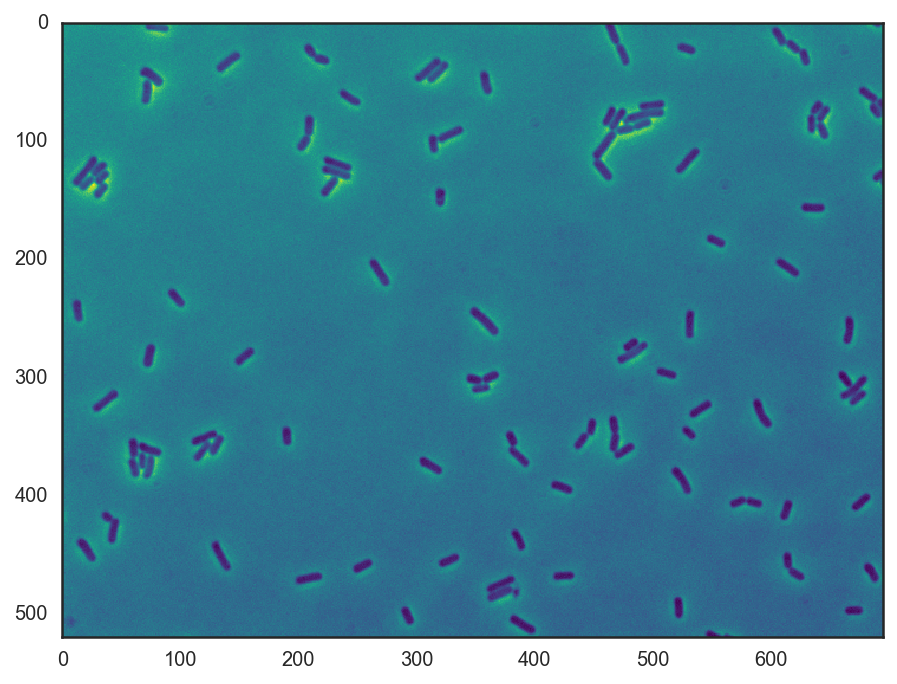

In [7]:
# Display phase image with false coloring (could also use plt.cm.RdBu_r)
with sns.axes_style('white'):
    plt.imshow(im, cmap=plt.cm.viridis)

We see some unevenness in illumination, going from the upper right to the lower left.  We might correct this by computing the background and doing a background subtraction.  We compute the background analogously to how we computed it when we were doing smoothing.  We use a strong Gaussian smoothing and subtract it.  The principle is the same.  The differences are only in the details.

1. When you apply a Gaussian filter in image processing, it is often called a **Gaussian blur**.  
2. The Gaussian filter is implemented in `skimage.filters.gaussian_filter`.  Its first argument is the image to filter and the second is `sigma`, which is the standard deviation of the Gaussian filter.  As is always the case in using built-in filters and image processing tools, **everything is in units of pixels**.
3. When applying a Gaussian filter, or any continuous transform to an image, the integer nature of the pixel values is typically lost.  `skimage` will automatically convert the images to floats upon filtering.  This can be dangerous, though.  It assumes that because the image is 16-bit that the maximal pixel value allowed is 65535.  It then makes a linear mapping of pixel values where 0 maps to 0 and 65535 maps to unity.  I prefer to have more control over data types and convert my images ahead of time.  To be safe, because I will be comparing many different snapshots, I will allow the maximal pixel value to be 65535, which means that all of our floating point pixel values will be close to each other, sacrificing about two digits worth of numerical precision.  This is not a big deal, and it's worth it not to risk improperly scaling images.  *A word of warning*, though: some of the image processing routines are designed to only work on integer pixel values, so you should always be careful about data types when doing image processing operations!  **Read the docs!**

We will try $\sigma = 50$ pixels to give a strong blur.

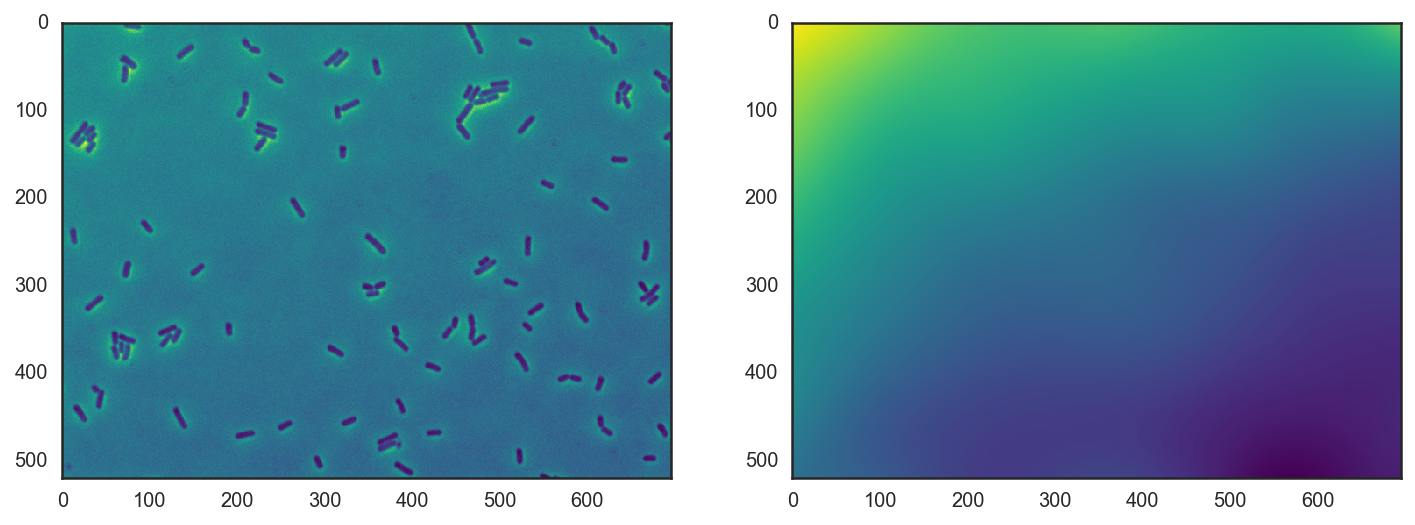

In [8]:
# Convert image to float
im_float = skimage.img_as_float(im)

# Filter the image with a strong Gaussian blur
im_bg = skimage.filters.gaussian_filter(im_float, 50.0)

# Show the image and its background
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    ax[0].imshow(im_float, cmap=plt.cm.viridis)
    ax[1].imshow(im_bg, cmap=plt.cm.viridis)

We see that the blurred image roughly gives the background luminescence.  We can subtract this from the original image and view it.

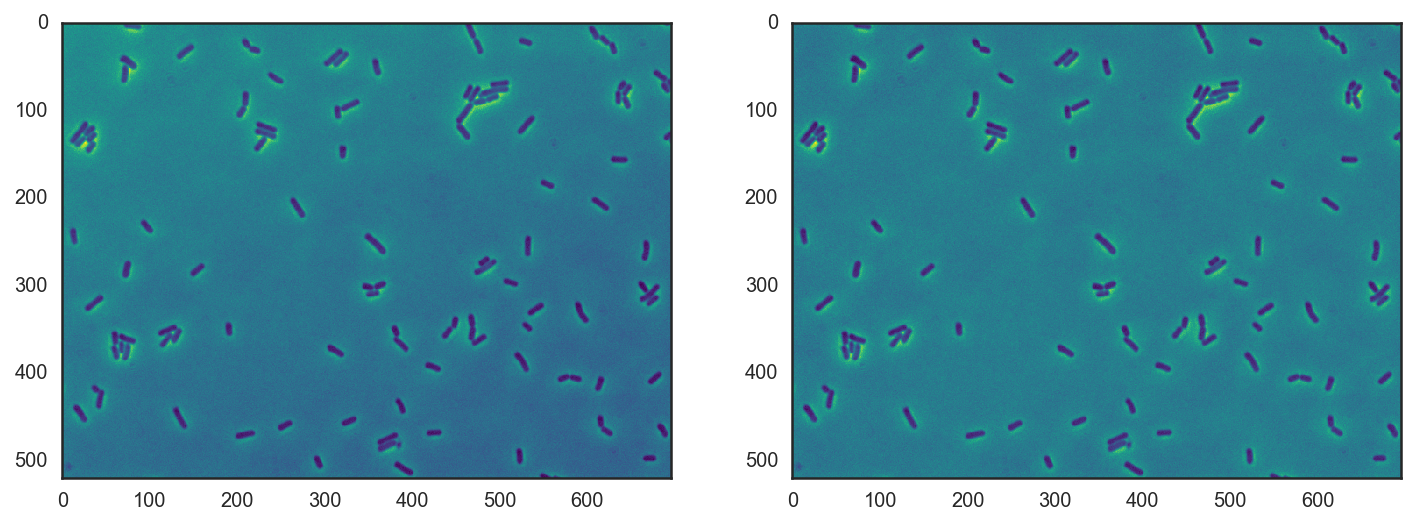

In [9]:
# Subtract background
im_no_bg = im_float - im_bg

# Show images
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(im_float, cmap=plt.cm.viridis)
    ax[1].imshow(im_no_bg, cmap=plt.cm.viridis)

Now the background is more uniform.  This is a simple way of doing background subtraction.  You can read another technique using **morphological reconstruction** [here](http://scikit-image.org/docs/dev/auto_examples/plot_regional_maxima.html).

### Denoising images

If we zoom in on the image, we can see that there is some noise, particularly in the background.

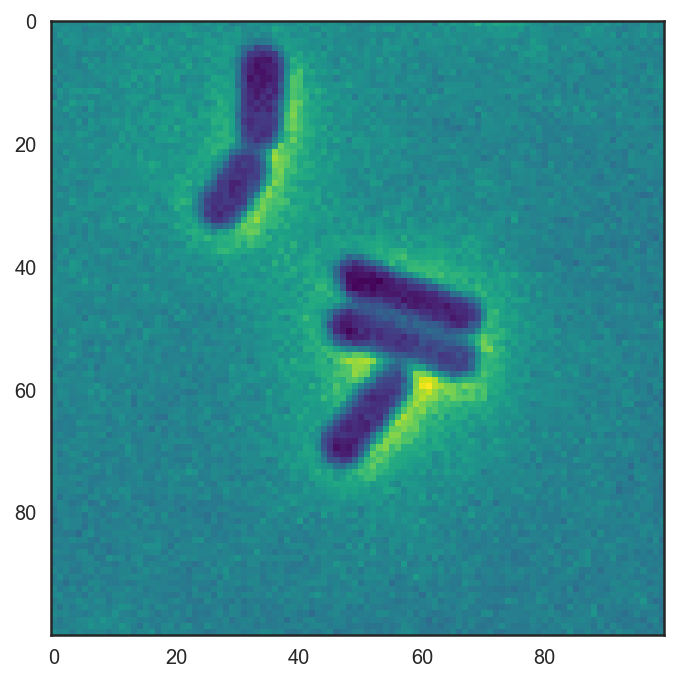

In [10]:
# Display zoom phase image
with sns.axes_style('white'):
    plt.imshow(im[75:175, 175:275], cmap=plt.cm.viridis)

A simple way to reduce the noise is to apply a Gaussian filter, this time, of course, with a smaller $\sigma$.  We will try $\sigma = 1$ pixel.

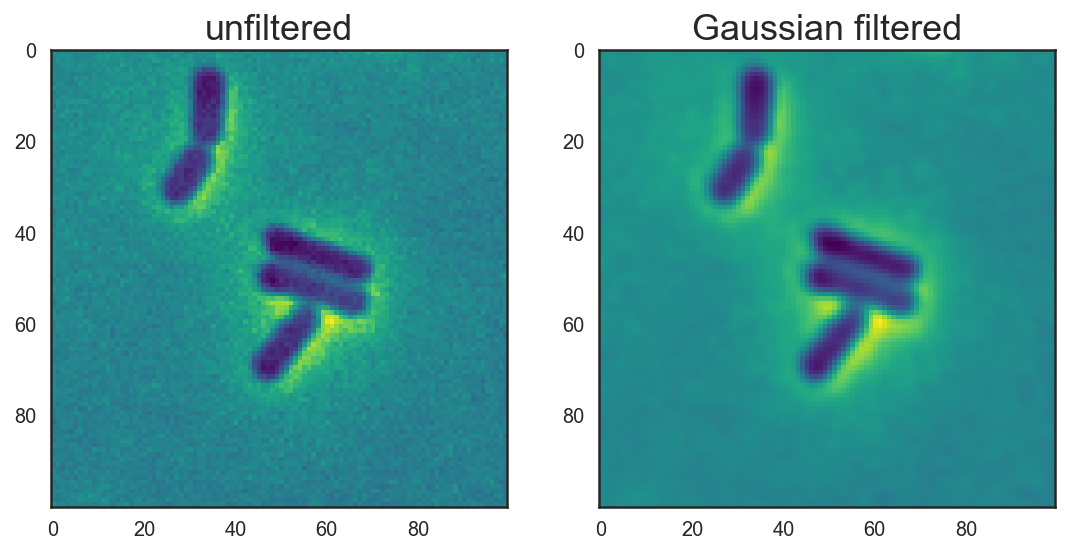

In [11]:
# Filter image
im_filt_gauss = skimage.filters.gaussian_filter(im_float, 1)

# Show filtered image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float[75:175, 175:275], cmap=plt.cm.viridis)
    ax[0].set_title('unfiltered')
    ax[1].imshow(im_filt_gauss[75:175, 175:275], cmap=plt.cm.viridis)
    ax[1].set_title('Gaussian filtered')

Next, we'll try a **total variation filter**.  These filters a similar to smoothing by regularization that we studied in [Tutorial 7a](../../tutorials/t7a_time_series.html).  The idea is that areas with large gradients are smoothed out, as this implied rapid fluctuation of pixel intensity values (noise).  We will use a Chambolle total variation filter.  This is implemented in `skimage.restoration.denoise_tv_chambolle`.  The first argument is the image to filter.  The second argument describes the degree of smoothing.

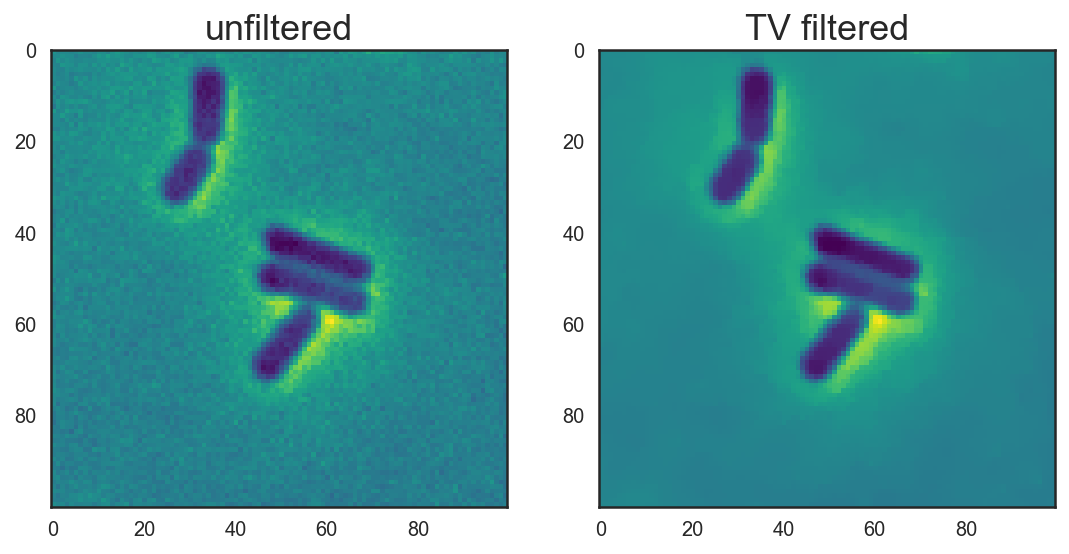

In [12]:
# Filter image
im_filt_tv = skimage.restoration.denoise_tv_chambolle(im_float, 0.001)

# Show filtered image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float[75:175, 175:275], cmap=plt.cm.viridis)
    ax[0].set_title('unfiltered')
    ax[1].imshow(im_filt_tv[75:175, 175:275], cmap=plt.cm.viridis)
    ax[1].set_title('TV filtered')

**Median filtering** is another effective technique to eliminate [salt-and-pepper noise](http://en.wikipedia.org/wiki/Salt-and-pepper_noise).  It is worth demonstrating this filter because it introduces the concept of a **structuring element**.  The concept is best illustrated through example.  In the case of median filtering, the value of the center pixel of some neighborhood of pixels of a given shape is replaced by the median of the pixel values around it.  The neighborhood is defined by the structuring element.  It could be a disk, a square, a cross, or anything else you might design.  For example, let's look at a disc structuring element or radius 10.

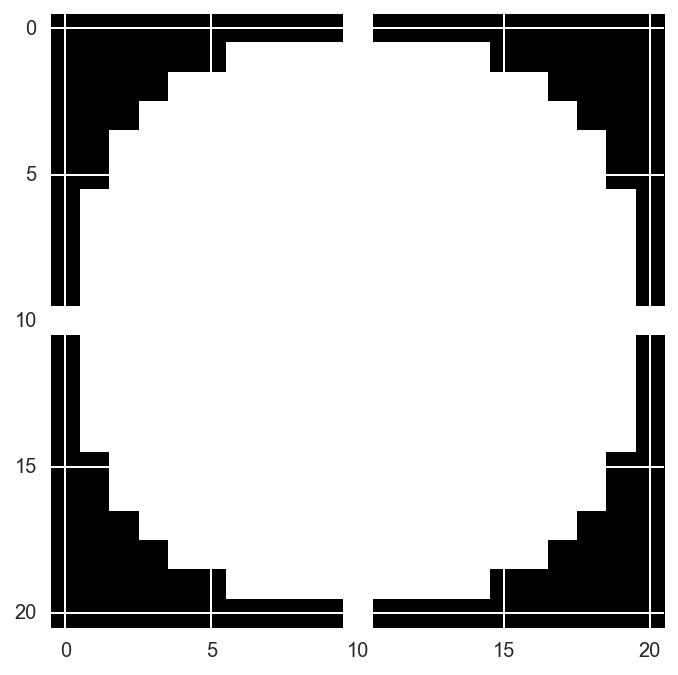

In [13]:
selem = skimage.morphology.disk(10)
plt.imshow(selem, cmap=plt.cm.gray)

So, in a median filter using this disk as a structuring element works by passing this disk over the image.  The pixel value at the center of the disk is replaced by the median of all values within the disk.

To illustrate median filtering, we will damage our image by introducing salt and pepper noise.  **Note: `skimage`'s median filter only works on `uint8` or `uint16` images.**

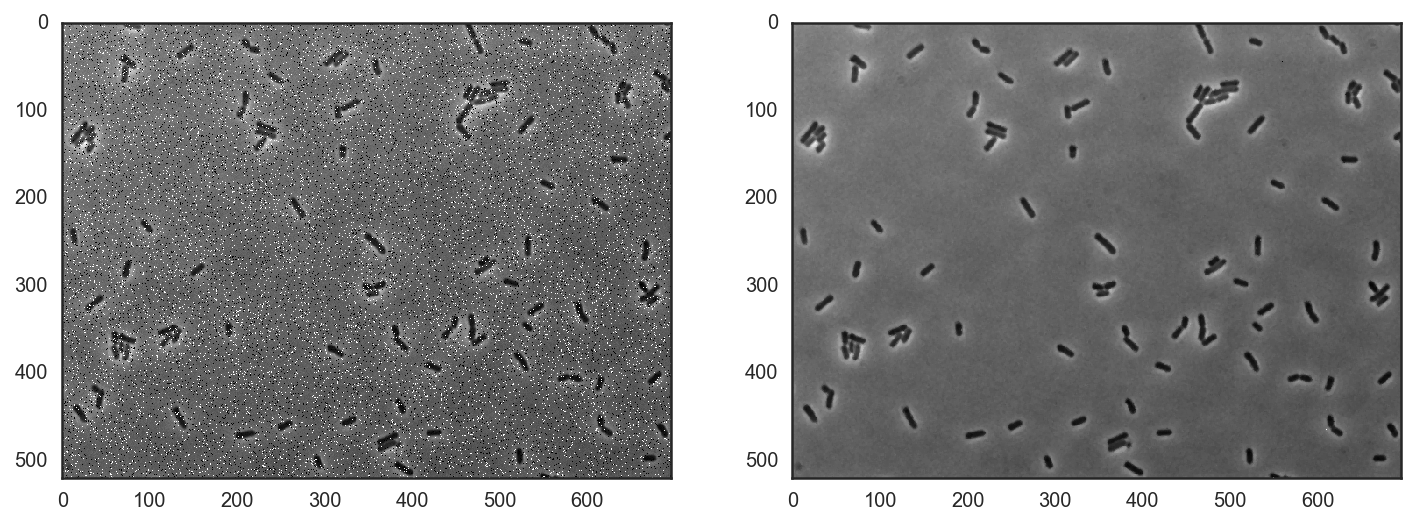

In [14]:
# Introduce salt and pepper noise
np.random.seed(42)
noise = np.random.random(im.shape)
im_snp = np.copy(im)
im_snp[noise > 0.96] = im.max()
im_snp[noise < 0.04] = im.min()

# Use a median filter in a small square structuring element for median filter
selem = skimage.morphology.square(3)
im_snp_filt = skimage.filters.rank.median(im_snp, selem)

# Show results
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(im_snp, cmap=plt.cm.gray)
    ax[1].imshow(im_snp_filt, cmap=plt.cm.gray)

Countless other filters exist, but we will not go into them here.  The available filters are described in the [`skimage` documentation](http://scikit-image.org/docs/dev/api/api.html).

Now, we will move on to **thresholding**.

## Thresholding

Thresholding is the process by which we convert an image into a **binary image** containing ones and zeros.  This is often an important part of segmentation.  The idea is that we want to label as `True` regions that are bacteria and `False` regions that are background (or vice versa).  Looking at the histogram again may help us understand this process.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


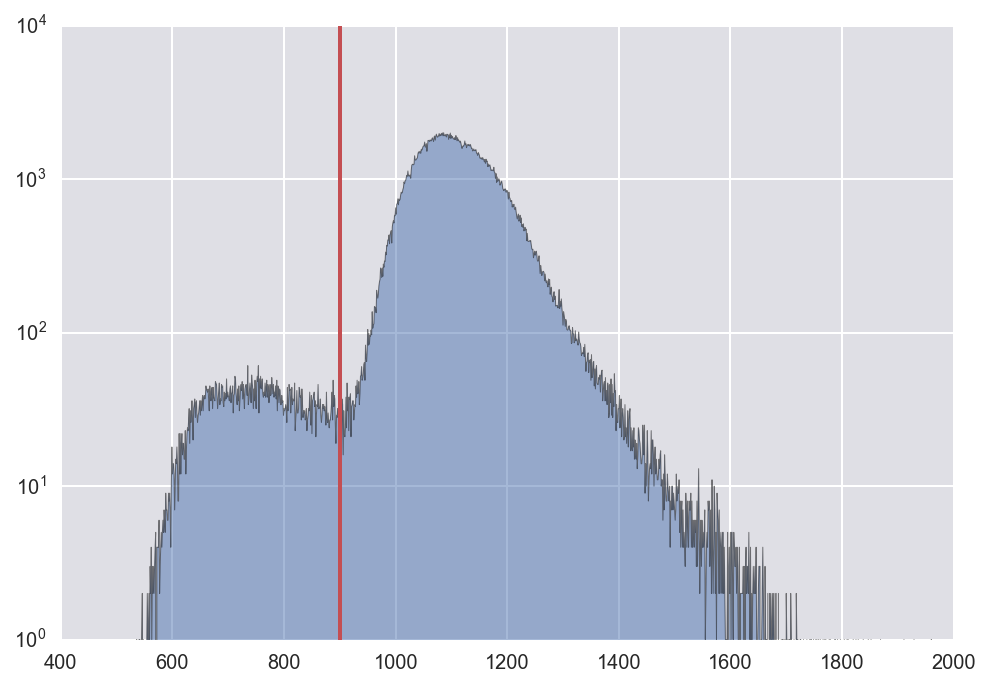

In [15]:
# Display histogram with log scale
plt.fill_between(bins[0], hist[0], lw=0.5, alpha=0.5)
plt.vlines(900, 1, 1e4, color=sns.color_palette()[2])
plt.yscale('log')

We see that the background has fallen off at pixel values of about 900.  So, we could naively choose all pixels greater than 900 to be background and those below to be bacteria.  Let's try that.

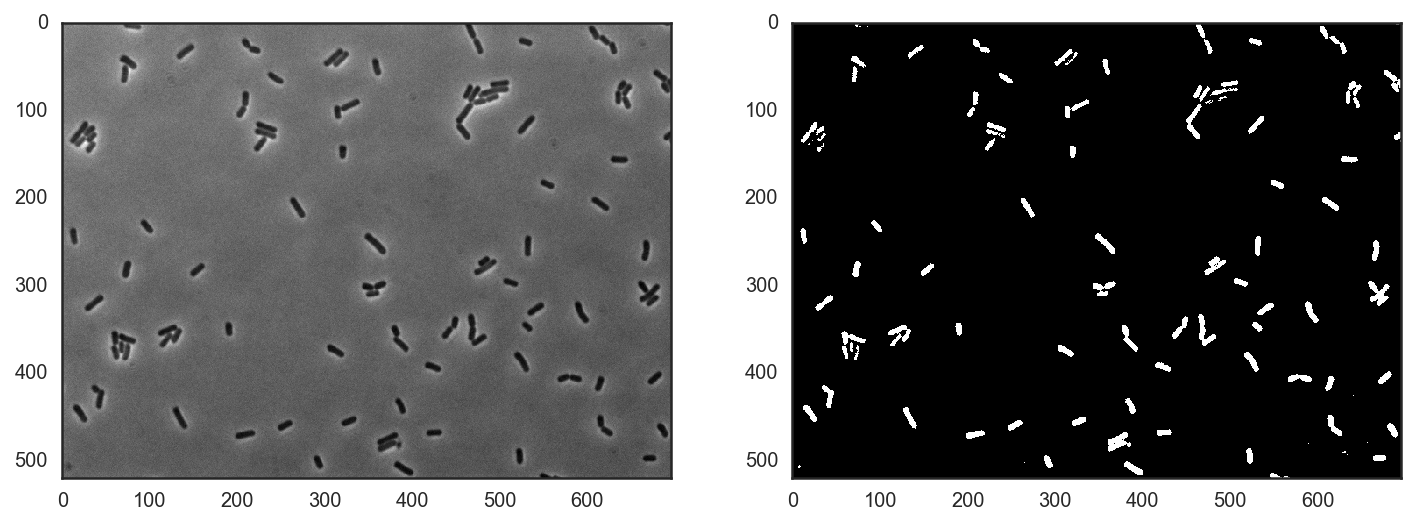

In [16]:
# Threshold image
thesh = 900
im_bw = im < 900

# Take a look
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(im, cmap=plt.cm.gray)
    ax[1].imshow(im_bw, cmap=plt.cm.gray)

It looks like we didn't do that badly.  Let's zoom in to check.

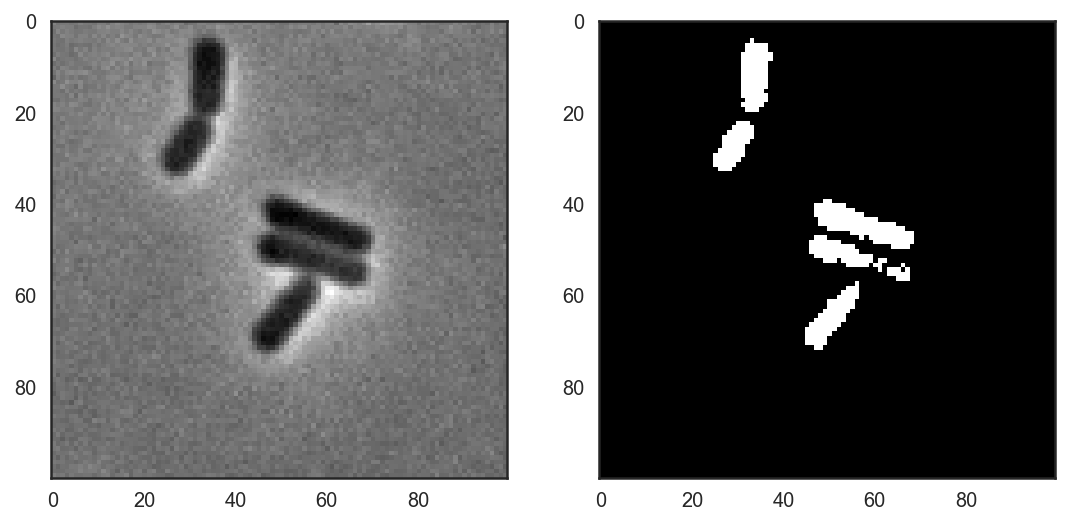

In [17]:
# Show filtered image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im[75:175, 175:275], cmap=plt.cm.gray)
    ax[1].imshow(im_bw[75:175, 175:275], cmap=plt.cm.gray)

We see that some pixels that are bacteria are deleted.  We would like to do better.  There are countless ways to do thresholding, and any method that gives a binary image at the end could work.  For example, we could only keep pixels that are below a *local* mean pixel value.  To do this, we use a morphological filter to convert each pixel to the mean of a local neighborhood (with the neighborhood again being defined by a structuring element), and then compare pixel values to that mean.  This has the effect of locally thresholding the image, resulting in insensitivity to background lighting.  We will take the neighborhood to be bigger than a typical bacterium.

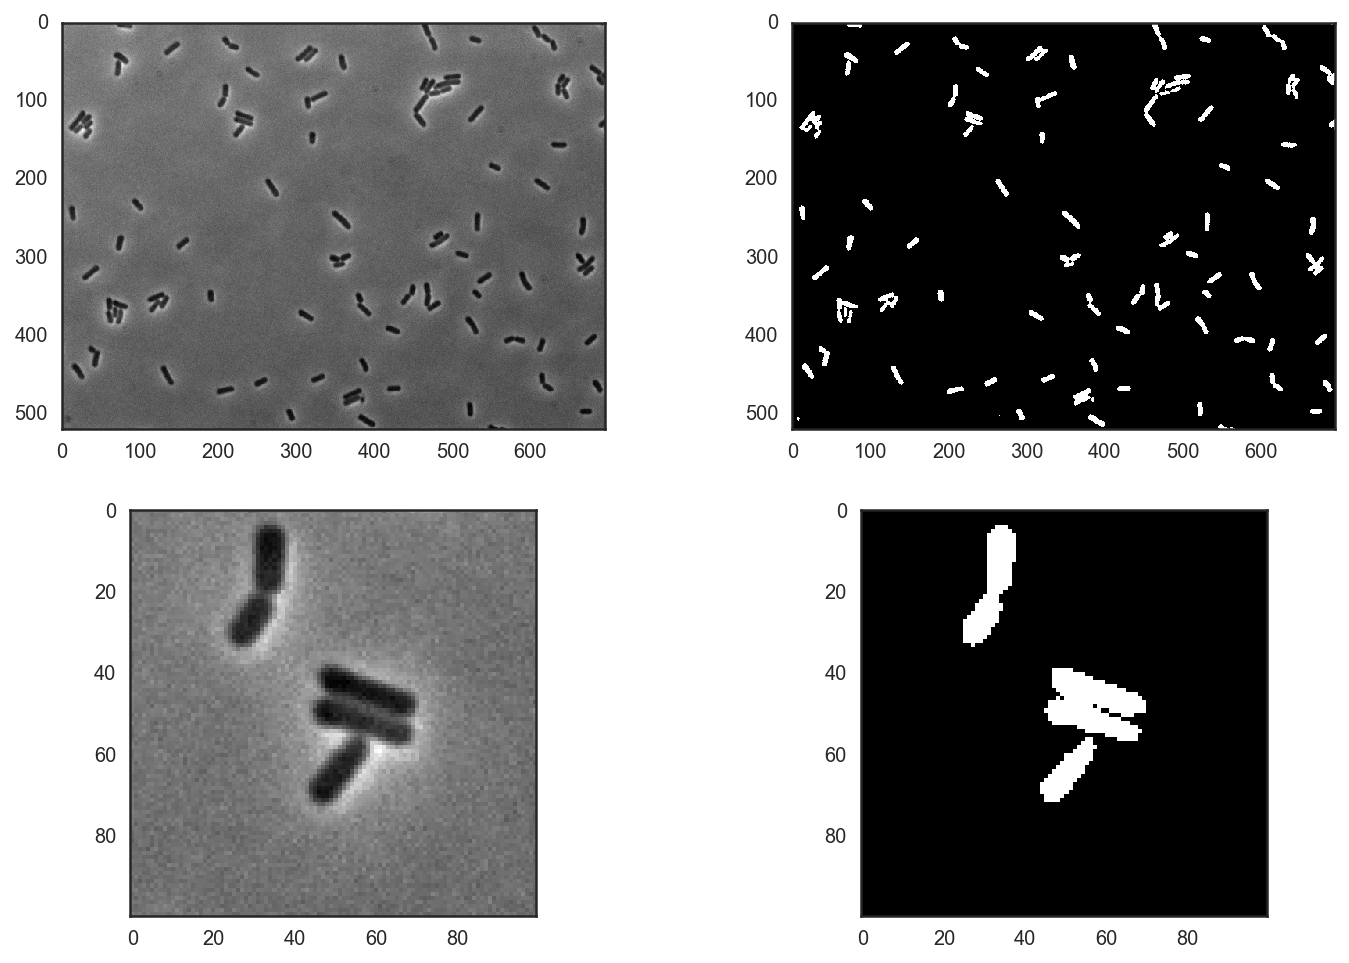

In [18]:
# Make the structuring element 25 pixel radius disk
selem = skimage.morphology.disk(25)

# Do the mean filter
im_mean = skimage.filters.rank.mean(im, selem)

# Threshhold based on mean filter
im_bw = im < 0.85 * im_mean

# Show the result
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    ax[0,0].imshow(im, cmap=plt.cm.gray)
    ax[0,1].imshow(im_bw, cmap=plt.cm.gray)
    ax[1,0].imshow(im[75:175, 175:275], cmap=plt.cm.gray)
    ax[1,1].imshow(im_bw[75:175, 175:275], cmap=plt.cm.gray)

We thresholded based on pixel values being below 85% of the local mean.  We would like to have an automated way to choose this value.  We could adopt a strategy where we look at how many pixels are added to the thresholded image as a function of this parameter (which we'll call $k$).  We choose the cutoff to be where we start adding the most pixels, which would mean we're starting to add background.  We can do this by computing the second derivative.

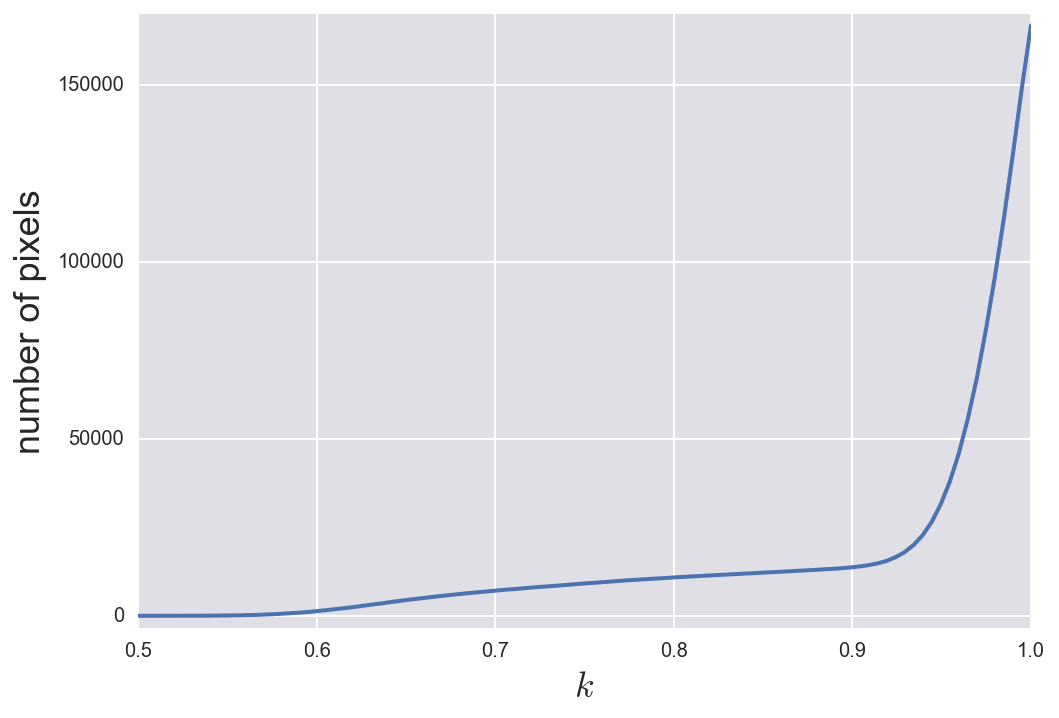

In [19]:
# Compute number of pixels in binary image as a function of k
k = np.linspace(0.5, 1.0, 100)
n_pix = np.empty_like(k)
for i in range(len(k)):
    n_pix[i] = (im < k[i] * im_mean).sum()

# Plot the result    
plt.plot(k, n_pix)
plt.xlabel('$k$')
plt.ylabel('number of pixels')
plt.xlim((0.5, 1.0));
plt.margins(0.02)

We'll now compute the second derivative and select a value of $k$ for which it is maximal.

Optimal k =  0.954545454545


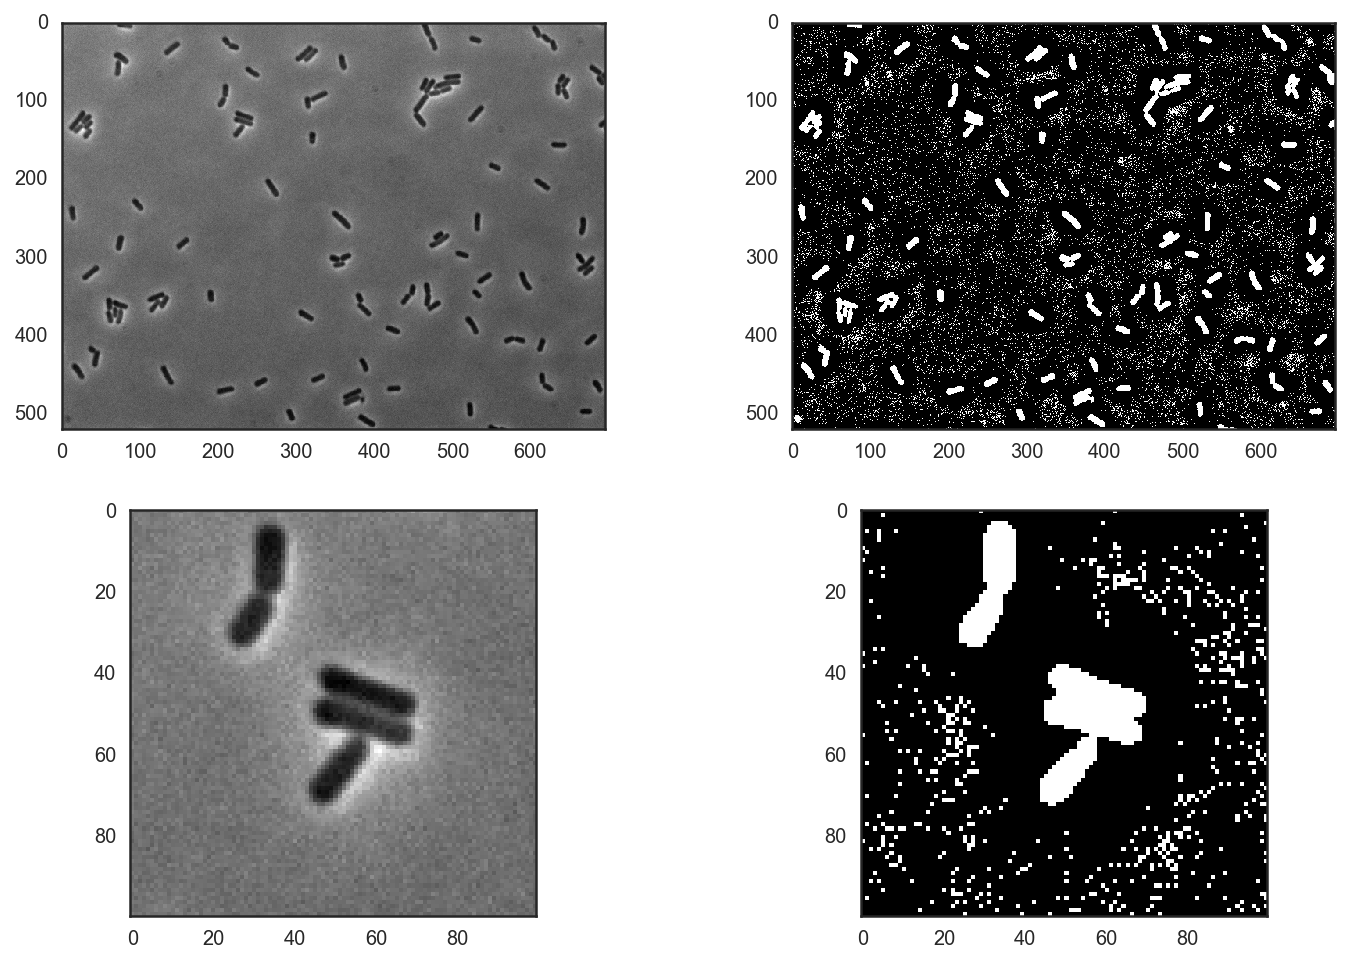

In [20]:
# Compute rough second derivative
dn_pix_dk2 = np.diff(np.diff(n_pix))

# Find index of maximal second derivative
max_ind = np.argmax(dn_pix_dk2)

# Use this index to set k
k_opt = k[max_ind-2]

# Re-threshold with this k
im_bw = im < k_opt * im_mean

# Report the result
print('Optimal k = ', k_opt)

# Show images
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    ax[0,0].imshow(im, cmap=plt.cm.gray)
    ax[0,1].imshow(im_bw, cmap=plt.cm.gray)
    ax[1,0].imshow(im[75:175, 175:275], cmap=plt.cm.gray)
    ax[1,1].imshow(im_bw[75:175, 175:275], cmap=plt.cm.gray)

We have lots of little regions laying around from the background, but these are easily removed using `skimage.morphology.remove_small_objects`.  Since a bacterium is at least 20 $\times$ 5 pixels (1.3$\times$0.3 µm) in size, we delete any objects smaller than 100 total pixels.

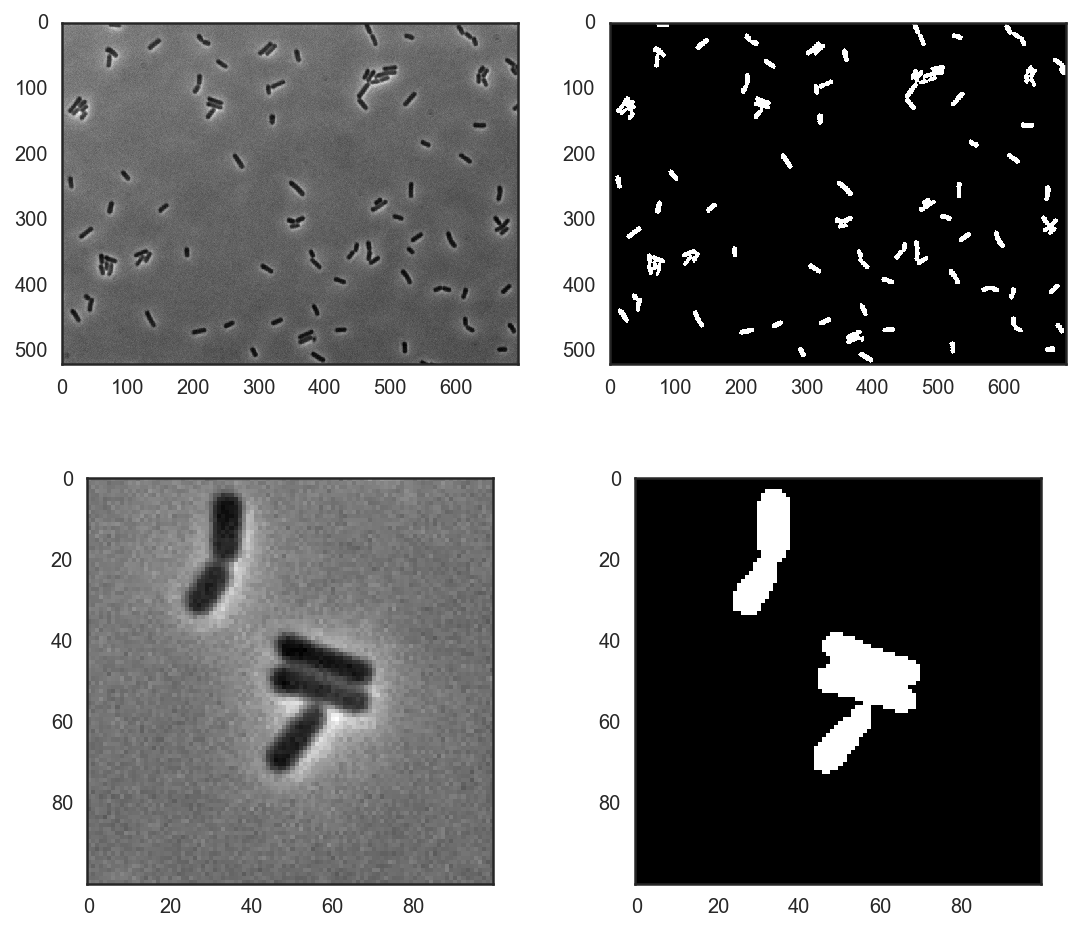

In [21]:
# Remove all the small objects
im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

# Show images
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 2, figsize=(9,8))
    ax[0,0].imshow(im, cmap=plt.cm.gray)
    ax[0,1].imshow(im_bw, cmap=plt.cm.gray)
    ax[1,0].imshow(im[75:175, 175:275], cmap=plt.cm.gray)
    ax[1,1].imshow(im_bw[75:175, 175:275], cmap=plt.cm.gray)

This is a pretty nice result.  We could code up our own thresholding function to do this.

In [22]:
def bebi103_thresh(im, selem, white_true=True, k_range=(0.5, 1.5), 
                   min_size=100):
    """
    Threshold image as described above.  Morphological mean filter is 
    applied using selem.
    """    
    # Determine comparison operator
    if white_true:
        compare = np.greater
        sign = -1
    else:
        compare = np.less
        sign = 1
    
    # Do the mean filter
    im_mean = skimage.filters.rank.mean(im, selem)

    # Compute number of pixels in binary image as a function of k
    k = np.linspace(k_range[0], k_range[1], 100)
    n_pix = np.empty_like(k)
    for i in range(len(k)):
        n_pix[i] = compare(im, k[i] * im_mean).sum() 

    # Compute rough second derivative
    dn_pix_dk2 = np.diff(np.diff(n_pix))

    # Find index of maximal second derivative
    max_ind = np.argmax(sign * dn_pix_dk2)

    # Use this index to set k
    k_opt = k[max_ind - sign * 2]

    # Threshold with this k
    im_bw = compare(im, k_opt * im_mean)

    # Remove all the small objects
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=min_size)
   
    return im_bw, k_opt

Let's take our function for a spin!

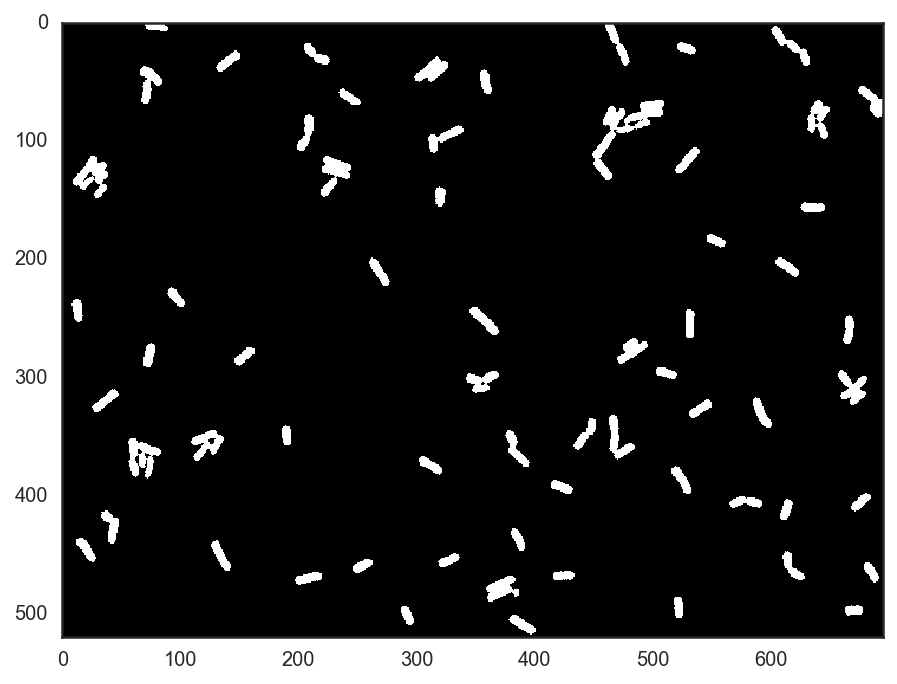

In [23]:
im_thresh, k = bebi103_thresh(im, skimage.morphology.disk(25), white_true=False,
                              min_size=100)

with sns.axes_style('white'):
    skimage.io.imshow(im_thresh, cmap=plt.cm.gray)

The purpose of this little exercise in thresholding is not to push the thresholding method we developed as *the* way to threshold.  It most certainly is not.  I hoped to show that there are straightforward ways we can go about thresholding an image, which is often the first step toward segmentation.

## A first step in morphological processing: opening

Let's look at some of our bacteria in our favorite zoomed region again.

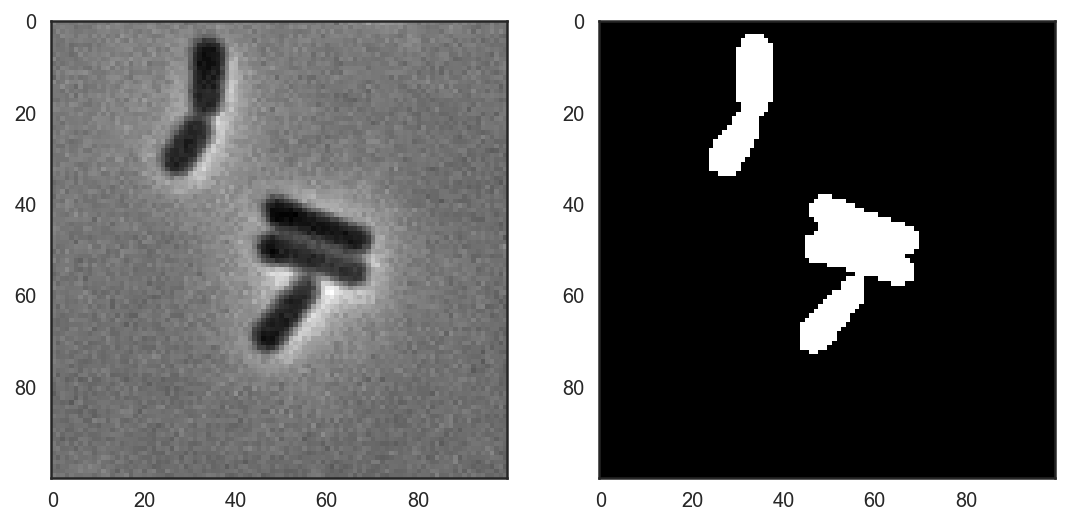

In [24]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    ax[0].imshow(im[75:175, 175:275], cmap=plt.cm.gray)
    ax[1].imshow(im_bw[75:175, 175:275], cmap=plt.cm.gray);

We see that bacteria that we would like to be separate are in fact joined together.  We would like to separate them.  Two common morphological operations that might help us are **erosion** and **dilation**.  The former whittles away the edges of white regions, while the latter expands them.  For erosion, as the structuring element is passed over the image, if all white pixels lie within the structuring element, the central pixel stays white.  Otherwise, it becomes black.  For dilation, if *any* of the white pixels lie within the structuring element, the central pixel becomes white.  Let's try eroding our image.

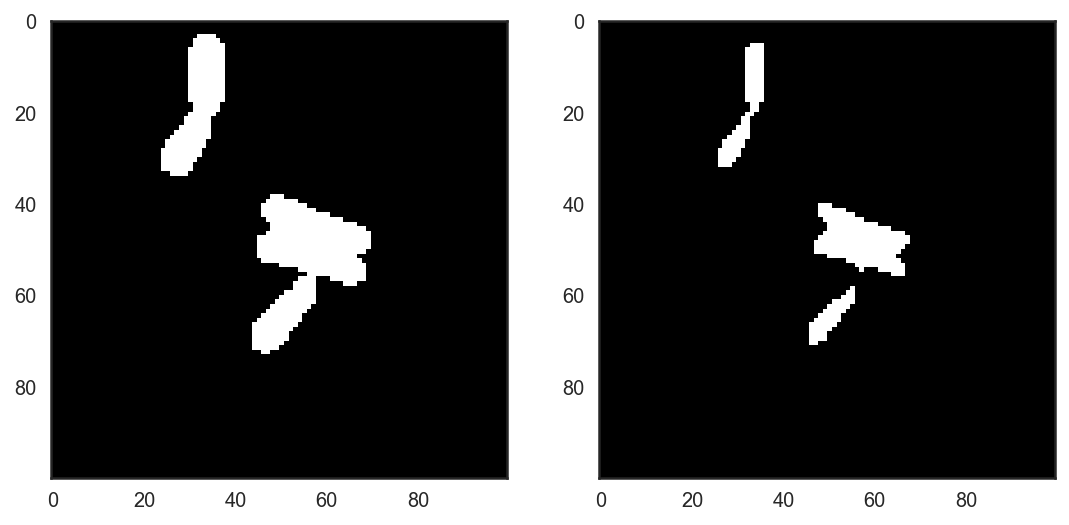

In [25]:
# Structuring element is radius 2 disk
selem = skimage.morphology.disk(2)

# Erode binary image
im_bw_eroded = skimage.morphology.erosion(im_bw, selem)

# Look at the result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    ax[0].imshow(im_bw[75:175, 175:275], cmap=plt.cm.gray)
    ax[1].imshow(im_bw_eroded[75:175, 175:275], cmap=plt.cm.gray);

We managed to disconnect one of the bacteria.  We should put the pixels we lost back in, though, using dilation.

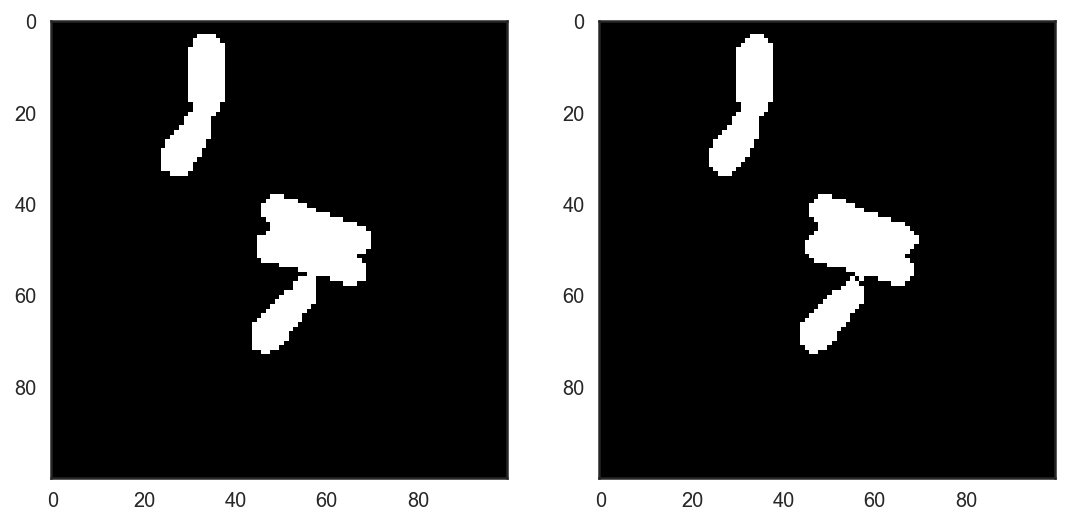

In [26]:
# Dilate eroded image
im_bw_redilated = skimage.morphology.dilation(im_bw_eroded, selem)

# Look at the result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    ax[0].imshow(im_bw[75:175, 175:275], cmap=plt.cm.gray)
    ax[1].imshow(im_bw_redilated[75:175, 175:275], cmap=plt.cm.gray);

This operation, of eroding and then dilating, is called **opening**.  The opposite is **closing**.  Opening tends to disconnect blobs and closing connects them.  Here, we only managed to disconnect one of the bacteria.  We can directly open a binary image using `skimage.morphology.binary_opening`.

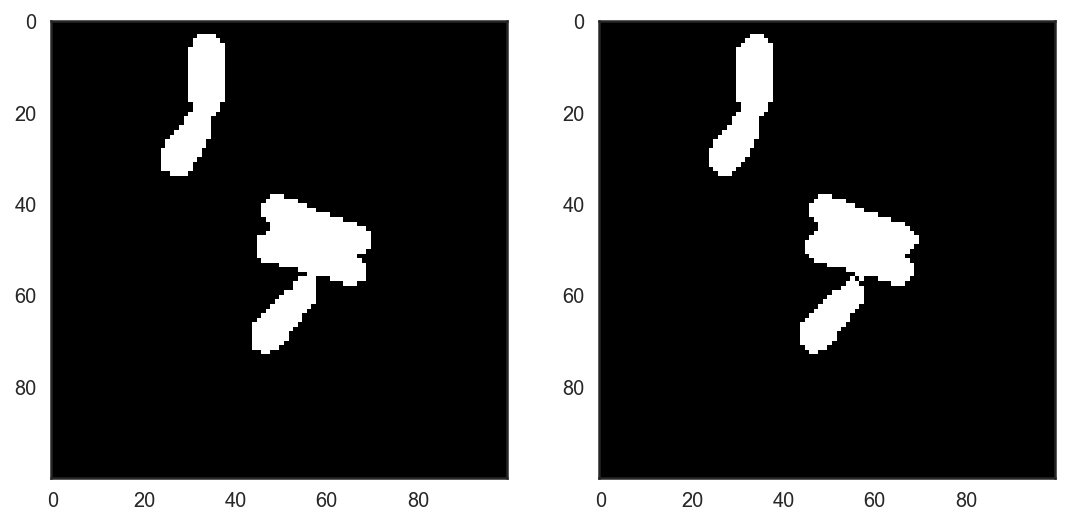

In [27]:
# Structuring element is radius 2 disk
selem = skimage.morphology.disk(2)

# Erode binary image
im_bw_opened = skimage.morphology.binary_opening(im_bw, selem)

# Show result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    ax[0].imshow(im_bw[75:175, 175:275], cmap=plt.cm.gray)
    ax[1].imshow(im_bw_redilated[75:175, 175:275], cmap=plt.cm.gray);

Separating the other bacteria is difficult.  It is better to have better images to use for segmentation, which is why the RFP channel is so useful.